In [1]:
import sys
sys.path.append('../')

import matlab.engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt.sampler import Lhs
from skopt.space import Space
import math
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from scipy.stats import norm
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from sklearn.neighbors import KernelDensity
from numpy.random import uniform
from sklearn.preprocessing import MinMaxScaler
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
from Hypervolume import HyperVolume
import optproblems.zdt
import ConfigSpace as CS
import sys
import matplotlib.pyplot as plt
from ZDT import ZDT1
from Problem import Problem
from MOTPE import MOTPE

eng = matlab.engine.start_matlab()
random_seed = 1990

In [2]:
def function_noiseless(x):
    # Rows are the dimensions and columns are the points
    D = x.shape[0]
#     f = optproblems.wfg.WFG4(2, D, 1)
    f = optproblems.zdt.ZDT1(D)
    fitness = np.array(f.objective_function(x))
        
    return fitness

Taken from https://datacrayon.com/posts/search-and-optimisation/practical-evolutionary-algorithms/synthetic-objective-functions-and-zdt1/

In [3]:
def function_noisy(x, replications, rng, constants, level=1, case=1):  
#     return a matrix of r replications x M objectives
#     x is a point
    f = np.zeros((replications, constants.shape[0])) 
#     print(f.shape)
    
    fr = function_noiseless(x) 
    for m in range(f.shape[1]): #for each objective
        a = constants[m,0];
        t = constants[m,1];        
        
        temp = []
        for r in range(replications):
            noise = rng.normal(loc=0, scale=(a*fr[m]+a*t))
            f[r, m] = fr[m] + noise
            
    return f

In [4]:
def optimal_set():
    true_front = np.empty((0, 2))

    for f1 in np.linspace(0, 1, num=1000):
        f2 = 1 - np.sqrt(f1)
        true_front = np.vstack([true_front, [f1, f2]])  

    true_front = pd.DataFrame(true_front, columns=['f1', 'f2'])  # convert to DataFrame
    return np.asarray(true_front)

In [5]:
def heterogeneus_noise(objectives, level=1, case=1, rep_budget=5):
    M = objectives.shape[1]
    linear_const = np.zeros((M, 2))
    noise_sd_range = np.zeros((M, 2))
    
    for m in range(M):
        obj_i = objectives[:, m]
        rank_obj_i = np.sort(obj_i)[::-1]
        rank_obj_i[0] = 1 if m ==1 else 10
        rank_obj_i[-1] = 0
        range_obj_i = np.abs(rank_obj_i[0]-rank_obj_i[-1]);
        
        #Bounds for noise s.d.
        if level == 1:
            lower_obj_i = 0.01/np.sqrt(rep_budget)*range_obj_i;
            upper_obj_i = 0.5/np.sqrt(rep_budget)*range_obj_i;
        elif level == 2:
            lower_obj_i = 0.5/np.sqrt(rep_budget)*range_obj_i;
            upper_obj_i =1.5/np.sqrt(rep_budget)*range_obj_i;
        else:
            lower_obj_i = 1/np.sqrt(rep_budget)*range_obj_i;
            upper_obj_i =2/np.sqrt(rep_budget)*range_obj_i;
            
#         print(lower_obj_i, upper_obj_i, range_obj_i)
#         print("rank ", rank_obj_i[0],  rank_obj_i[-1])
        if case == 1: #Best case
            b_obj_i = (rank_obj_i[0]*lower_obj_i-rank_obj_i[-1]*upper_obj_i)/(upper_obj_i-lower_obj_i);
            a_obj_i = lower_obj_i/(rank_obj_i[-1]+b_obj_i);
        else: #Worst case
            b_obj_i = (rank_obj_i[-1]*lower_obj_i-rank_obj_i[0]*upper_obj_i)/(upper_obj_i-lower_obj_i);
            a_obj_i = lower_obj_i/(rank_obj_i[0]+b_obj_i);
        
#         print(a_obj_i, b_obj_i)
#         print("---------------")
        
        min_noise = a_obj_i * rank_obj_i[-1] + a_obj_i * b_obj_i;   
        max_noise = a_obj_i * rank_obj_i[0] + a_obj_i * b_obj_i;

        linear_const[m,0] = a_obj_i;
        linear_const[m,1] = b_obj_i;
        noise_sd_range[m,0] = min_noise;
        noise_sd_range[m,1] = max_noise;
            
    return linear_const

In [6]:
def plot_pf(non_dominated_points, true_points, solutions):
    
    m = np.mean(non_dominated_points, axis=1)
    std =  np.sqrt(np.var(non_dominated_points, axis=1))
    max_data = m+std #np.max(non_dominated_points, axis=1)
    min_data = m-std #np.min(non_dominated_points, axis=1)
    
    ells = [Ellipse(xy=[m[i,0], m[i,1]], 
                    width=np.abs(max_data[i,0]-min_data[i,0]), 
                    height=np.abs(max_data[i,1]-min_data[i,1]))
            for i in range(m.shape[0])]

    fig, ax = plt.subplots(figsize=(10,10))

    index = 0
    for e in ells:
        ax.add_patch(e)
        
        if index==0:
            e.set(clip_box=ax.bbox, alpha=0.2, facecolor="peachpuff", edgecolor='silver', label='Uncertainty')
        else:
            e.set(clip_box=ax.bbox, alpha=0.2, facecolor="peachpuff", edgecolor='silver')
        index+=1
        
#         e.set_edgecolor('silver')
    max_axes = np.max([max_data[:,0], max_data[:,1]])
    ax.set_xlim(0, max_axes+.5)
    ax.set_ylim(0, max_axes+.5)

    ax.scatter(m[:, 0], m[:, 1], color='k', s=50, 
               zorder=len(ells)+1, label="Observed PF")
    ax.scatter(tf[:,0], tf[:,1], label="Optimal PF")
    ax.scatter(solutions[:, 0], solutions[:, 1], color='orange', marker='+', zorder=len(ells)+2, label="Solutions")
    ax.legend()
    return ax

In [7]:
def compute_hypervolume(m, referencePoint):
    hv = HyperVolume(referencePoint)
    volume = hv.compute(m)
    return volume

In [8]:
def pareto_front(points, level=0, index=False):

    points = points.copy()
    ranks = np.zeros(len(points))
    r = 0
    c = len(points)
    while c > 0:
        extended = np.tile(points, (points.shape[0], 1, 1))
        dominance = np.sum(np.logical_and(
            np.all(extended <= np.swapaxes(extended, 0, 1), axis=2),
            np.any(extended < np.swapaxes(extended, 0, 1), axis=2)), axis=1)
        points[dominance == 0] = 1e9  # mark as used
        ranks[dominance == 0] = r
        r += 1
        c -= np.sum(dominance == 0)
    if index:
#         return ranks
        return [i for i in range(len(ranks)) if ranks[i] == level] 
    else:    
        ind = [i for i in range(len(ranks)) if ranks[i] == level]
        return points[ind]

In [9]:
def acquisition_function(candidates, model, Z_min, score_tpe=0):
    BK = np.asarray([np.ones(candidates.shape[0])])
    BK = matlab.double(np.transpose(BK).tolist())

    [SK_gau, SK_gau_mse, det_mse]  = eng.SKpredict_new(model, matlab.double(candidates.tolist()), BK, 
                                              matlab.double(np.asarray([random_seed]).tolist()),
                                              nargout=3)
    SK_gau = np.asarray(SK_gau)
    det_mse = np.asarray(det_mse)
    mse = np.sqrt(np.abs(det_mse))
    
    mei = (Z_min-SK_gau) * norm.cdf((Z_min-SK_gau)/mse,0,1) + mse * norm.pdf((Z_min-SK_gau)/mse,0,1) + score_tpe
#     print("mei", mei, mei.shape)
    return -mei[:,0]

In [10]:
eps = sys.float_info.epsilon

seed                = random_seed   #args.seed
num_variables       = 5     #args.num_variables
num_initial_samples = 11*num_variables-1    #args.num_initial_samples
num_max_evals       = 130   #args.num_max_evals
num_objectives      = 2     #args.num_objectives
replications        = 50

k                   = 1     #args.k
num_candidates      = 1000    #args.num_candidates
init_method         = 'lhs' #args.init_method
gamma               = 0.1   #args.gamma
base_configuration  = {
    'num_objectives': num_objectives,
    'num_variables': num_variables,
    'replications':replications,
    'k': k,
    'seed': seed}
benchmark_name      = "ZDT1" #args.benchmark_name

f       = ZDT1(benchmark_name, base_configuration)
cs      = f.make_cs(CS.ConfigurationSpace(seed=seed))
problem = Problem(f, cs)
solver  = MOTPE(seed=seed)

range_objectives = np.asarray([[1, 10],
                              [0, 0]])
constants = solver.prepare_heterogeneus_noise(range_objectives, rep_budget=replications)
cs, i = solver.init_model(
    {'num_initial_samples': num_initial_samples,
     'num_max_evals': num_max_evals,
     'init_method': init_method,
     'num_candidates': num_candidates,
     'scalarize':False,
     'gamma': gamma},
        problem)
# data = solver.history_replications()
# X = solver.get_X()
hv_history = []
W = solver.get_weights_scalarization()

Sampling initial points: 
     0.0 %
     1.85 %
     3.7 %
     5.56 %
     7.41 %
     9.26 %
     11.11 %
     12.96 %
     14.81 %
     16.67 %
     18.52 %
     20.37 %
     22.22 %
     24.07 %
     25.93 %
     27.78 %
     29.63 %
     31.48 %
     33.33 %
     35.19 %
     37.04 %
     38.89 %
     40.74 %
     42.59 %
     44.44 %
     46.3 %
     48.15 %
     50.0 %
     51.85 %
     53.7 %
     55.56 %
     57.41 %
     59.26 %
     61.11 %
     62.96 %
     64.81 %
     66.67 %
     68.52 %
     70.37 %
     72.22 %
     74.07 %
     75.93 %
     77.78 %
     79.63 %
     81.48 %
     83.33 %
     85.19 %
     87.04 %
     88.89 %
     90.74 %
     92.59 %
     94.44 %
     96.3 %
     98.15 %


In [11]:


#Optimization procedure
for it in range(num_max_evals):   
    print("Iteration: ", it, "/", num_max_evals)
    
    data = solver.history_replications()
    X = solver.get_X()

    #Prepare de optimization
    Y_mean=np.zeros(data.shape[0])
    Vhat=np.zeros(data.shape[0])
    B = np.asarray([np.ones(data.shape[0])])

    #### Scalarization
    # Randomly select a point
    weight = W[np.random.randint(0, W.shape[0]),:]
    
    for i in range(data.shape[0]):
        point = np.asarray(data[i])
        pcheby_term1 = np.max(point * np.tile(weight, (replications,1)), axis=1)
        pcheby_term2 = np.sum(point * np.tile(weight, (replications,1)), axis=1)
        pcheby = pcheby_term1 + 0.05*pcheby_term2
        Y_mean[i] = np.mean(pcheby);
        Vhat[i] = np.var(pcheby)/replications;
    Vhat = np.asarray([Vhat]).T
    #Normalize objectives
    scaler = MinMaxScaler()
    Y_mean = scaler.fit_transform(np.asarray([Y_mean]).T)
    
    
#     print(X.shape, Y_mean.shape, B.T.shape, Vhat.shape)
    
    X_matlab = matlab.double(X.tolist())
    Y_matlab = matlab.double(Y_mean.tolist())
    B = matlab.double(np.transpose(B).tolist())
    Vhat = matlab.double(Vhat.tolist())

    skriging_model_2 = eng.SKfit_new(X_matlab,Y_matlab, B, Vhat, 2, 3, 
                                     matlab.double(np.asarray([random_seed]).tolist()), nargout=1);
    
#     ######### SELECTION ########
    # Select the best point and evaluate it wh SK
    index_best = Y_mean.argmin(axis=0)[0]
    X_matlab = matlab.double(np.asarray(X[index_best,:]).tolist())

    [SK_gau, SK_gau_mse]  = eng.SKpredict_new(skriging_model_2, X_matlab, 
                                              matlab.double(np.asarray([1]).tolist()), 
                                              matlab.double(np.asarray([random_seed]).tolist()),
                                              nargout=2);
    SK_gau_array = np.asarray(SK_gau)
    sample = solver.sample(cs)
    

    # Select the point sampled from l that maximize the MEI
    meis = acquisition_function(sample, skriging_model_2, SK_gau_array)
    best_mei = meis.argmin(axis=0)
    pos = sample[best_mei]
    solver.add_infill_point(problem, pos, i)
    
    m = np.mean(data, axis=1)
    pf = pareto_front(m, index=True)
    pf = data[pf]
    volume=compute_hypervolume(np.mean(pf, axis=1), [1, 10])
    hv_history.append(volume)
#     plot_evolution(X, XK, skriging_model_2, truthk, it)

Iteration:  0 / 130
Iteration:  1 / 130
Iteration:  2 / 130
Iteration:  3 / 130
Iteration:  4 / 130
Iteration:  5 / 130
Iteration:  6 / 130
Iteration:  7 / 130
Iteration:  8 / 130
Iteration:  9 / 130
Iteration:  10 / 130
Iteration:  11 / 130
Iteration:  12 / 130
Iteration:  13 / 130
Iteration:  14 / 130
Iteration:  15 / 130
Iteration:  16 / 130
Iteration:  17 / 130
Iteration:  18 / 130
Iteration:  19 / 130
Iteration:  20 / 130
Iteration:  21 / 130
Iteration:  22 / 130
Iteration:  23 / 130
Iteration:  24 / 130
Iteration:  25 / 130
Iteration:  26 / 130
Iteration:  27 / 130
Iteration:  28 / 130
Iteration:  29 / 130
Iteration:  30 / 130
Iteration:  31 / 130
Iteration:  32 / 130
Iteration:  33 / 130
Iteration:  34 / 130
Iteration:  35 / 130
Iteration:  36 / 130
Iteration:  37 / 130
Iteration:  38 / 130
Iteration:  39 / 130
Iteration:  40 / 130
Iteration:  41 / 130
Iteration:  42 / 130
Iteration:  43 / 130
Iteration:  44 / 130
Iteration:  45 / 130
Iteration:  46 / 130
Iteration:  47 / 130
It

In [17]:
lhs = solver.get_X()
lhs = lhs[:num_initial_samples,:]

df = pd.DataFrame(lhs)
df.to_csv("lhs.csv")

In [16]:
# Save the replications
rep = solver.history_replications()
mmm = pd.DataFrame(rep.reshape(rep.shape[0]*rep.shape[1],2))
mmm.to_csv("replications_GP_MOTPE_ZDT1.csv")

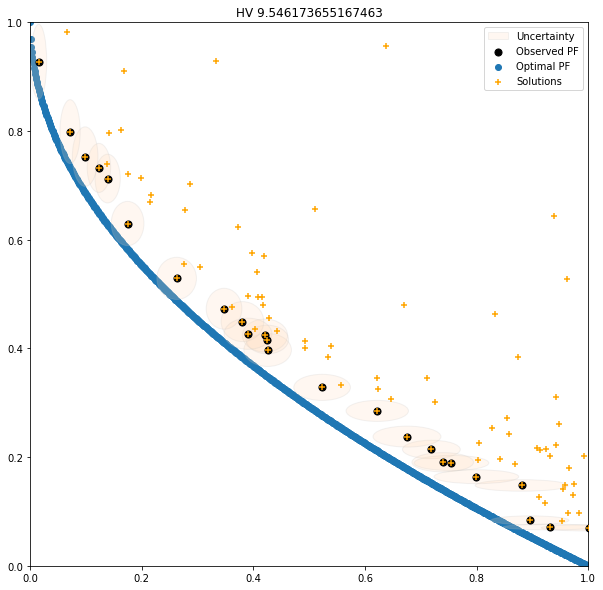

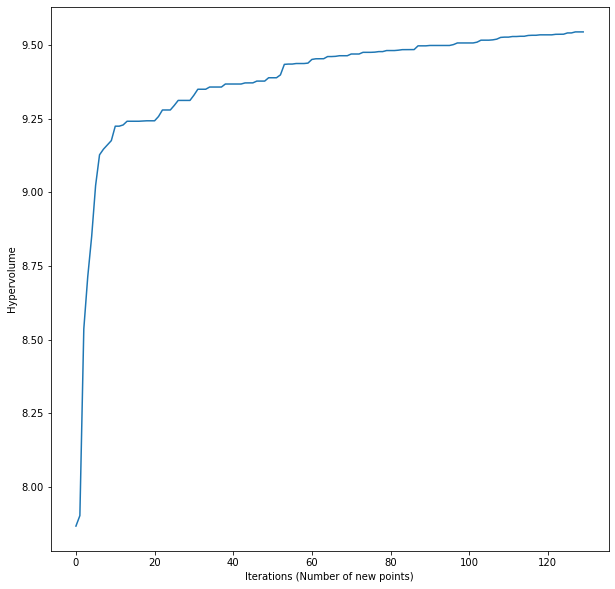

In [13]:
# Save the exploration
m = solver.get_F()
df = pd.DataFrame(m)
df.to_csv("exploration_GP_MOTPE_ZDT1.csv")

data = solver.history_replications()
m = np.mean(data, axis=1)
pf = pareto_front(m, index=True)
pf = data[pf]
volume=compute_hypervolume(np.mean(pf, axis=1), [1, 10])

tf = optimal_set()
ax = plot_pf(pf, tf, m)
plt.title("HV "+str(volume))
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend()
plt.savefig('PF_GP_MOTPE.png', dpi=1200, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10,10))
plt.plot(hv_history)
plt.xlabel("Iterations (Number of new points)")
plt.ylabel("Hypervolume")
plt.savefig('HV_GP_MOTPE.png', dpi=1200, bbox_inches='tight')


# Save the hyervolume history
df = pd.DataFrame(hv_history)
df.to_csv("hypervolume_GP_MOTPE_ZDT1.csv")

In [14]:
data = solver.history_replications()
m = np.mean(data, axis=1)
hv_temp = []

for index in range(num_initial_samples, len(m)):
    pf = pareto_front(m[:index], index=True)
    pf = data[pf]
    volume=compute_hypervolume(np.mean(pf, axis=1), [1, 10])
    hv_temp.append(volume)

Text(0, 0.5, 'Hypervolume')

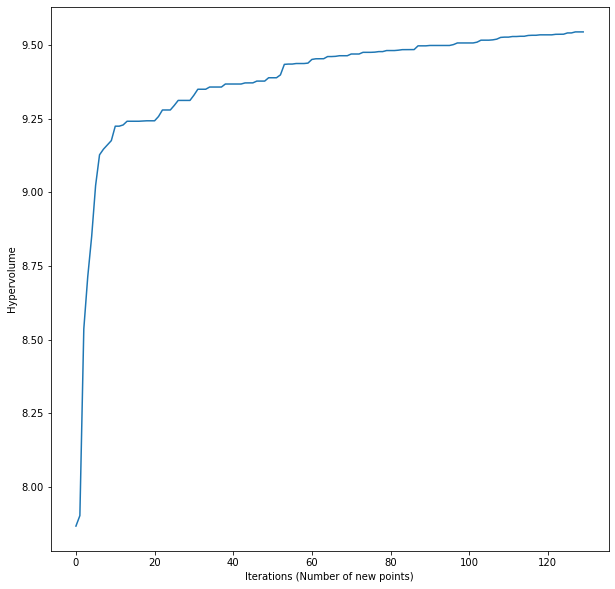

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(hv_temp)
plt.xlabel("Iterations (Number of new points)")
plt.ylabel("Hypervolume")